# Adding average uniqueness and weights

In [75]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sys
sys.path.insert(0, '..')
from multiprocess import mp_pandas_obj

In [76]:
# events = pd.read_csv("../data/events.csv", index_col=0, parse_dates=[0, 1])
t1 = pd.to_datetime(pd.read_csv("../data/t1.csv", index_col=0, parse_dates=True, squeeze=True))
df = pd.read_csv("../data/BTCUSDT-volume-bars.csv", index_col=0, parse_dates=True)

In [77]:
def mp_num_co_events(close_idx,t1,molecule):
    '''
    Compute the number of concurrent events per bar.
    +molecule[0] is the date of the first event on which the weight will be computed
    +molecule[-1] is the date of the last event on which the weight will be computed
    
    Any event that starts before t1[modelcule].max() impacts the count.
    '''
    #1) find events that span the period [molecule[0],molecule[-1]]
    t1=t1.fillna(close_idx[-1]) # unclosed events still must impact other weights
    t1=t1[t1>=molecule[0]] # events that end at or after molecule[0]
    t1=t1.loc[:t1[molecule].max()] # events that start at or before t1[molecule].max()
    #2) count events spanning a bar
    iloc=close_idx.searchsorted(np.array([t1.index[0],t1.max()]))
    count=pd.Series(0,index=close_idx[iloc[0]:iloc[1]+1])
    for t_in,t_out in t1.iteritems():
        count.loc[t_in:t_out]+=1.
    return count.loc[molecule[0]:t1[molecule].max()]

In [78]:
num_co_events = mp_pandas_obj(mp_num_co_events,('molecule',t1.index),                         
                              1,close_idx=df.index,t1=t1)

In [79]:
num_co_events

2021-04-23 07:31:43.163    1.0
2021-04-23 07:31:44.212    1.0
2021-04-23 07:31:45.347    1.0
2021-04-23 07:31:47.652    1.0
2021-04-23 07:31:50.047    1.0
                          ... 
2021-06-19 14:15:34.209    1.0
2021-06-19 14:15:55.327    1.0
2021-06-19 14:16:06.552    1.0
2021-06-19 14:16:18.285    1.0
2021-06-19 14:16:39.233    1.0
Length: 998093, dtype: float64

## Get average uniqueness of a label

In [80]:
def mp_sample_tw(t1,num_co_events,molecule):
    # Derive avg. uniqueness over the events lifespan
    wght=pd.Series(index=molecule, dtype=float)
    for t_in,t_out in t1.loc[wght.index].iteritems():
        wght.loc[t_in]=(1./num_co_events.loc[t_in:t_out]).mean()
    return wght

In [88]:
out=pd.DataFrame()
out['au'] = mp_pandas_obj(mp_sample_tw,('molecule',t1.index),
                            1,t1=t1,num_co_events=num_co_events)
out

,au
2021-04-23 07:31:43.163,0.231878
2021-04-23 08:09:56.981,0.156455
2021-04-23 08:31:35.814,0.141238
2021-04-23 09:40:37.273,0.122657
2021-04-23 10:06:50.048,0.118390
...,...
2021-06-18 03:49:00.094,0.144524
2021-06-18 10:02:30.206,0.162493
2021-06-18 10:57:56.538,0.167922
2021-06-18 13:13:03.131,0.203347


## Determination of sample weight by absolute return attribution

In [89]:
def mp_sample_w(t1,num_co_events,close,molecule):
    # Derive sample weight by return attribution
    ret=np.log(close).diff() # log-returns, so that they are additive
    wght=pd.Series(index=molecule, dtype=float)
    for t_in,t_out in t1.loc[wght.index].iteritems():
        wght.loc[t_in]=(ret.loc[t_in:t_out]/num_co_events.loc[t_in:t_out]).sum()
    return wght.abs()

In [90]:
## example ##
out['w']=mp_pandas_obj(mp_sample_w,('molecule',t1.index),1,
                         t1=t1,num_co_events=num_co_events,close=df.close)
out['w']*=out.shape[0]/out['w'].sum()

out

,au,w
2021-04-23 07:31:43.163,0.231878,1.222493
2021-04-23 08:09:56.981,0.156455,3.069675
2021-04-23 08:31:35.814,0.141238,1.220746
2021-04-23 09:40:37.273,0.122657,1.974526
2021-04-23 10:06:50.048,0.118390,0.723902
...,...,...
2021-06-18 03:49:00.094,0.144524,3.126947
2021-06-18 10:02:30.206,0.162493,1.358553
2021-06-18 10:57:56.538,0.167922,1.459584
2021-06-18 13:13:03.131,0.203347,0.917172


## Time decay

In [94]:
def get_time_decay(au,clf_last_w=1.,exponent=1):
    # apply optional exponential time decay to observed uniqueness (au)
    # newest observation gets weight=1, oldest observation gets weight=clf_last_w
    clf_w=au.sort_index().cumsum()
    if clf_last_w>=0: slope=((1.-clf_last_w)/clf_w.iloc[-1])**exponent
    else: slope=(1./((clf_last_w+1)*clf_w.iloc[-1]))**exponent
    const=1.-slope*clf_w.iloc[-1]
    clf_w=const+slope*clf_w
    clf_w[clf_w<0]=0
    print(round(const,4), round(slope,4))
    return clf_w

In [102]:
out['decay'] = get_time_decay(out['au'].dropna(), clf_last_w=.5, exponent=1)

0.5 0.0089


In [104]:
out['wd'] = out.w*out.decay

In [105]:
out

,au,w,decay,wd
2021-04-23 07:31:43.163,0.231878,1.222493,0.502052,0.613755
2021-04-23 08:09:56.981,0.156455,3.069675,0.503437,1.545388
2021-04-23 08:31:35.814,0.141238,1.220746,0.504687,0.616095
2021-04-23 09:40:37.273,0.122657,1.974526,0.505773,0.998662
2021-04-23 10:06:50.048,0.118390,0.723902,0.506821,0.366888
...,...,...,...,...
2021-06-18 03:49:00.094,0.144524,3.126947,0.993210,3.105713
2021-06-18 10:02:30.206,0.162493,1.358553,0.994648,1.351282
2021-06-18 10:57:56.538,0.167922,1.459584,0.996134,1.453942
2021-06-18 13:13:03.131,0.203347,0.917172,0.997934,0.915277


In [108]:
out.to_csv("../data/weighted_t1.csv")

## Plotting

Text(0.5, 1.0, 'Weight, Time decay, and Weighted time decay')

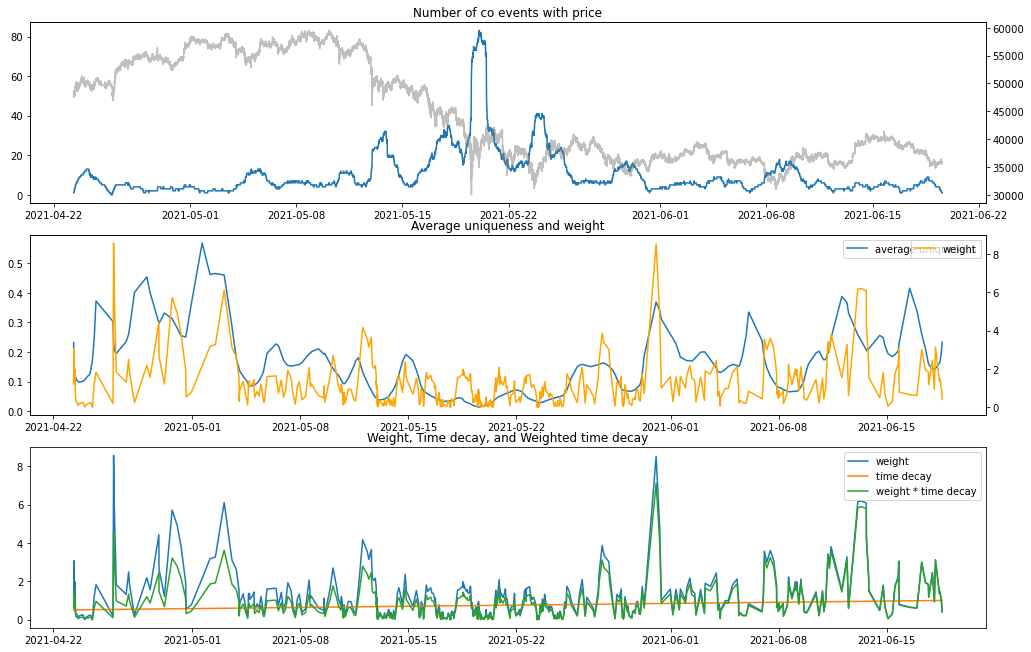

In [109]:
fig, [ax, ax1, ax3] = plt.subplots(3, figsize=(14, 9))
fig.tight_layout()

ax.plot(num_co_events)
ax.set_title("Number of co events with price")
ax0 = ax.twinx()
ax0.plot(df.reindex(num_co_events.index).close, color="gray", alpha=.5)

ax1.plot(out.au, label="average uniqueness")
ax1.set_title("Average uniqueness and weight")

ax2 = ax1.twinx()
ax2.plot(out.w, label="weight", color='orange')
ax1.legend()
ax2.legend()

ax3.plot(out.w, label="weight")
ax3.plot(out.decay, label = "time decay")
ax3.plot(out.wd, label = "weight * time decay")
ax3.legend()
ax3.set_title("Weight, Time decay, and Weighted time decay")